## Machine Learning with Spark - Lab

## Introduction

In the previous lesson, you saw how to manipulate data with Spark DataFrames as well as create machine learning models. In this lab, you're going to practice loading data, manipulating it, and fitting it in the Spark framework. Afterward, you're going to make use of different visualizations to see if you can get any insights from the model. This dataset is from a Taiwanese financial company, and the task is to determine which individuals are going to default on their credit card based off of characteristics such as limit balance, past payment history, age, marriage status, and sex. Let's get started!

### Objectives

In this lab you will: 

- Load and manipulate data using Spark DataFrames 
- Create a Spark ML pipeline that transforms data and runs over a grid of hyperparameters 

To begin with create a SparkSession and import the `'credit_card_default.csv'` file  into a PySpark DataFrame. 

In [2]:
# import necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
# initialize Spark Session
spark = SparkSession.builder.master('local').getOrCreate()

# read in csv to a spark dataframe
spark_df = spark.read.csv('credit_card_default.csv', header=True, inferSchema=True)

Check the datatypes to ensure that all columns are the datatype you expect.

In [3]:
spark_df.dtypes

[('ID', 'int'),
 ('LIMIT_BAL', 'double'),
 ('SEX', 'string'),
 ('EDUCATION', 'string'),
 ('MARRIAGE', 'string'),
 ('AGE', 'int'),
 ('PAY_0', 'int'),
 ('PAY_2', 'int'),
 ('PAY_3', 'int'),
 ('PAY_4', 'int'),
 ('PAY_5', 'int'),
 ('PAY_6', 'int'),
 ('BILL_AMT1', 'double'),
 ('BILL_AMT2', 'double'),
 ('BILL_AMT3', 'double'),
 ('BILL_AMT4', 'double'),
 ('BILL_AMT5', 'double'),
 ('BILL_AMT6', 'double'),
 ('PAY_AMT1', 'double'),
 ('PAY_AMT2', 'double'),
 ('PAY_AMT3', 'double'),
 ('PAY_AMT4', 'double'),
 ('PAY_AMT5', 'double'),
 ('PAY_AMT6', 'double'),
 ('default', 'int')]

Check to see how many missing values are in the dataset. This will require using the `.filter()` , `.isNull()`, and `.count()` methods.

In [8]:
for col in spark_df.columns:
    print(col, ':', spark_df.filter(spark_df[col].isNull()).count())

ID : 0
LIMIT_BAL : 0
SEX : 0
EDUCATION : 0
MARRIAGE : 0
AGE : 0
PAY_0 : 0
PAY_2 : 0
PAY_3 : 0
PAY_4 : 0
PAY_5 : 0
PAY_6 : 0
BILL_AMT1 : 0
BILL_AMT2 : 0
BILL_AMT3 : 0
BILL_AMT4 : 0
BILL_AMT5 : 0
BILL_AMT6 : 0
PAY_AMT1 : 0
PAY_AMT2 : 0
PAY_AMT3 : 0
PAY_AMT4 : 0
PAY_AMT5 : 0
PAY_AMT6 : 0
default : 0


In [ ]:
# There are no missing values in the data

Now, determine how many categories there are in each of the categorical columns.

In [10]:
for column, data_type in spark_df.dtypes:
    if data_type == 'string':
        print('Feature', column, 'has:', spark_df.select(column).distinct().collect())

Feature SEX has: [Row(SEX='Female'), Row(SEX='Male')]
Feature EDUCATION has: [Row(EDUCATION='High School'), Row(EDUCATION='0'), Row(EDUCATION='5'), Row(EDUCATION='6'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature MARRIAGE has: [Row(MARRIAGE='0'), Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Interesting... it looks like we have some extraneous values in each of our categories. Let's look at some visualizations of each of these to determine just how many of them there are. Create bar plots of the variables `'EDUCATION'` and `'MARRIAGE'` to see how many of the undefined values there are. After doing so, come up with a strategy for accounting for the extra values.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

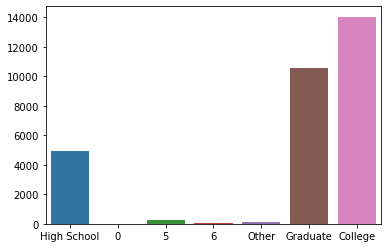

In [15]:
## plotting the categories for education
ed_counts = np.array(spark_df.groupBy('EDUCATION').count().collect())
sns.barplot(x=ed_counts[:,0], y=ed_counts[:,1].astype('float64'));

<AxesSubplot:>

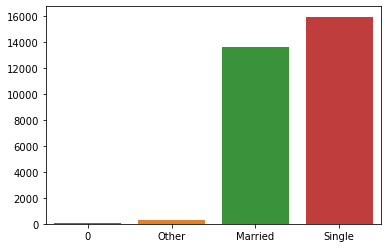

In [16]:
## plotting the categories for marriage
marriage_counts = np.array(spark_df.groupBy('MARRIAGE').count().collect())
sns.barplot(x=marriage_counts[:,0], y=marriage_counts[:,1].astype('float64'))

It looks like there are barely any of the 0 and 5 categories. We can go ahead and throw them into the "Other" category since it's already operating as a catchall here. Similarly, the category "0" looks small, so let's throw it in with the "Other" values. You can do this by using a method called `.when()` from PySpark in conjunction with `.withColumn()` and `.otherwise()`.  

In [17]:
from pyspark.sql.functions import when

## changing the values in the education column
spark_df_fix = spark_df.withColumn('EDUCATION', 
                                   when(spark_df.EDUCATION == '0', 'Other')\
                                   .when(spark_df.EDUCATION == '5', 'Other')\
                                   .when(spark_df.EDUCATION == '6', 'Other')\
                                   .otherwise(spark_df.EDUCATION)
                                  )
## changing the values in the marriage column

spark_df_done = spark_df_fix.withColumn('MARRIAGE',
                                        when(spark_df_fix.MARRIAGE == '0', 'Other')\
                                        .otherwise(spark_df.MARRIAGE)
                                       )

In [18]:
spark_df_done.head()

Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1)

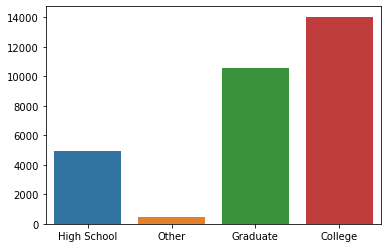

In [19]:
## plotting the categories for education
ed_counts = np.array(spark_df_done.groupBy('EDUCATION').count().collect())
sns.barplot(x=ed_counts[:,0], y=ed_counts[:,1].astype('float64'));

Now let's take a look at all the values contained in the categorical columns of the DataFrame: 

In [20]:
for column, data_type in spark_df_done.dtypes:
    if data_type == 'string':
        print('Feature', column, 'has:', spark_df_done.select(column).distinct().collect())

Feature SEX has: [Row(SEX='Female'), Row(SEX='Male')]
Feature EDUCATION has: [Row(EDUCATION='High School'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature MARRIAGE has: [Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Much better. Now, let's do a little more investigation into our target variable before diving into the machine learning aspect of this project.

##  EDA

Let's first look at the overall distribution of class balance of the default and not default labels. Create a barplot to compare the number of defaults vs. non-defaults. This will require using `.groupBy()` as well as an aggregation method.

In [25]:
default_counts = np.array(spark_df_done.groupBy('default').count().collect())
default_counts

array([[    1,  6635],
       [    0, 23364]])

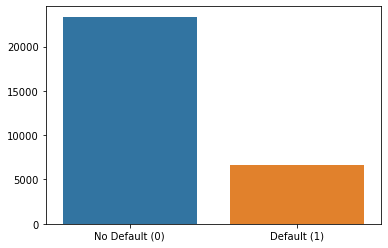

In [34]:
ax = sns.barplot(x=default_counts[:,0], y=default_counts[:,1])
ax.set_xticklabels(['No Default (0)', 'Default (1)']);

Let's also visualize the difference in default rate between males and females in this dataset.

In [35]:
# perform a groupby for default and sex
male_counts = np.array(spark_df_done.filter(spark_df_done.SEX == 'Male').groupBy('default').count().collect())
female_counts = np.array(spark_df_done.filter(spark_df_done.SEX == 'Female').groupBy('default').count().collect())

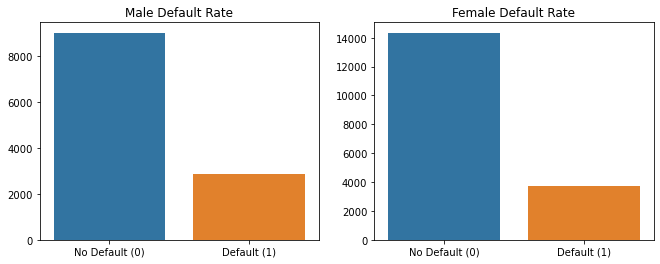

In [39]:
# make barplot for female and male default v no default rate
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
sns.barplot(x=male_counts[:, 0], y=male_counts[:, 1].astype('float64'), ax=ax1)
ax1.set_title('Male Default Rate')
ax1.set_xticklabels(['No Default (0)', 'Default (1)']);
sns.barplot(x=female_counts[:, 0], y=female_counts[:, 1].astype('float64'), ax=ax2)
ax2.set_title('Female Default Rate')
ax2.set_xticklabels(['No Default (0)', 'Default (1)']);

It looks like males have an ever so slightly higher default rate than females.

## Onto the Machine Learning!

Now, it's time to fit the data to the PySpark machine learning model pipeline. You will need:

* 3 StringIndexers (for each categorical feature)
* A OneHotEncoderEstimator (to encode the newly indexed strings into categorical variables)
* A VectorAssembler (to combine all features into one SparseVector)

All of these initialized estimators should be stored in a list.

In [40]:
spark_df_done.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default']

In [68]:
to_drop = ['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'default']

In [69]:
# importing the necessary modules
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, OneHotEncoderModel

# creating the string indexers
si1 = StringIndexer(inputCol='SEX', outputCol='sex_idx')
si2 = StringIndexer(inputCol='EDUCATION', outputCol='edu_idx')
si3 = StringIndexer(inputCol='MARRIAGE', outputCol='marriage_idx')

# features to be included in the model 
ohe = OneHotEncoder(inputCols=['sex_idx', 
                               'edu_idx', 
                               'marriage_idx'], 
                    outputCols=['sex_vec',
                                'edu_vec',
                                'marriage_vec'
                               ], dropLast=True)

# adding the categorical features
features = [col for col in spark_df_done.columns if col not in to_drop] + ohe.getOutputCols()


# putting all of the features into a single vector
vector_assembler = VectorAssembler(inputCols=features, outputCol='features')

stages = [si1, si2, si3, ohe, vector_assembler]
stages

[StringIndexer_6b9fc8607f8a,
 StringIndexer_a4048fd74ae6,
 StringIndexer_0ac9aa5759cc,
 OneHotEncoder_eabd98944e79,
 VectorAssembler_0cb82c429d8b]

Alright! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [70]:
from pyspark.ml.pipeline import Pipeline

pipeline = Pipeline(stages=stages)
# 17 numerical features and 6 categorical ones (the argument dropLast = True makes us have Sex, 3 Edu variables and 2 marriage)

In [71]:
pipe_transformer = pipeline.fit(spark_df_done)

In [72]:
transformed = pipe_transformer.transform(spark_df_done)
p = transformed.select('features')
p.head()

Row(features=DenseVector([120000.0, 26.0, -1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2682.0, 1725.0, 2682.0, 3272.0, 3455.0, 3261.0, 0.0, 1000.0, 1000.0, 1000.0, 0.0, 2000.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]))

## Fitting Machine Learning Models
That looks good! Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the `BinaryClassificationEvaluator`. Below is an import of all the classes and libraries you'll need in the remainder of this lab.

In [73]:
from pyspark.ml.classification import GBTClassifier, DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

### Logistic Regression

First, we'll try with a simple Logistic Regression Model:

* instantiate a logistic regression model
* add it to the stages list
* instantiate a new Pipeline estimator (not fit) with all of the stages
* instantiate an `BinaryClassificationEvaluator`
* create parameters to gridsearch through using `ParamGridBuilder`
* Instantiate and fit a `CrossValidator` 

In [74]:
logreg = LogisticRegression(featuresCol='features', labelCol='default')
logreg_stages = stages + [logreg]
logreg_pipe = Pipeline(stages=logreg_stages)

logreg_eval = BinaryClassificationEvaluator(labelCol='default')

logreg_params = ParamGridBuilder().addGrid(logreg.regParam, [0, 1, 5])\
                                  .addGrid(logreg.threshold, [0.4, 0.5, 0.6])\
                                  .addGrid(logreg.standardization, [True, False]).build()

logreg_cv = CrossValidator(estimator=logreg_pipe, estimatorParamMaps=logreg_params, evaluator=logreg_eval, parallelism=4)

In [75]:
logreg_cv_model = logreg_cv.fit(spark_df_done)

Determine how well your model performed by looking at the evaluator metrics. If you tried multiple parameters, which performed best?

In [76]:
# print out the AUC of your best model as well as the parameters of your best model
index_best_model = np.argmax(logreg_cv_model.avgMetrics)
print('AUC:', logreg_cv_model.avgMetrics[index_best_model])
print('best parameters :', logreg_params[index_best_model])

AUC: 0.7245243034507636
best parameters : {Param(parent='LogisticRegression_7818d4bc6ab9', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_7818d4bc6ab9', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.4, Param(parent='LogisticRegression_7818d4bc6ab9', name='standardization', doc='whether to standardize the training features before fitting the model.'): True}


In [77]:
logreg_cv_model.avgMetrics

[0.7245243034507636,
 0.7245243034507636,
 0.7245243034507636,
 0.7245243034507636,
 0.7245243034507636,
 0.7245243034507636,
 0.6996515905003896,
 0.7077159153259531,
 0.6996515905003896,
 0.7077159153259531,
 0.6996515905003896,
 0.7077159153259531,
 0.6959300298478327,
 0.6875494740822521,
 0.6959300298478327,
 0.6875494740822521,
 0.6959300298478327,
 0.6875494740822521]

#### Now try this again with other classifiers. Try and create a function that will allow you to easily test different models with different parameters. This function is optional, but it should allow for your code to be far more D.R.Y. The function should return the fitted cross-validated model as well as print out the performance metrics of the best performing model and the best parameters.

In [107]:
# create function to cross validate models with different parameters
def model_test(clf, param_grid, data, stages):
    stages = stages + [clf]
    pipe = Pipeline(stages=stages)
    
    clf_eval = BinaryClassificationEvaluator(labelCol='default')
    cv = CrossValidator(estimator=pipe, estimatorParamMaps=param_grid, evaluator=clf_eval, parallelism=4)
    cv_model = cv.fit(data)
    
    # Print best AUC and params
    index_best_model = np.argmax(cv_model.avgMetrics)
    print('AUC:', cv_model.avgMetrics[index_best_model])
    print('best parameters :', param_grid[index_best_model])
    
    # Return model
    return cv_model

Train a Random Forest classifier and determine the best performing model with the best parameters. This might take a while! Be smart about how you use parallelization here.

In [108]:
clf = RandomForestClassifier(featuresCol='features',
                             labelCol='default'
                            )
rf_grid = ParamGridBuilder().addGrid(clf.maxDepth, [10, 20, 30])\
                            .addGrid(clf.numTrees, [20, 30, 40])\
                            .addGrid(clf.minInstancesPerNode, [1, 5, 10]).build()

In [109]:
# code to train Random Forest Classifier
# ⏰ This cell may take a long time to run
rf_model = model_test(clf, rf_grid, spark_df_done, stages)

AUC: 0.7804486874834509
best parameters : {Param(parent='RandomForestClassifier_2e485eb6143f', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20, Param(parent='RandomForestClassifier_2e485eb6143f', name='numTrees', doc='Number of trees to train (>= 1).'): 40, Param(parent='RandomForestClassifier_2e485eb6143f', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 10}


Now train a Gradient Boosting Classifier. **This might take a very long time depending on the number of parameters you are training**

In [101]:
# code to train Gradient Boosting Classifier
# ⏰ This cell may take a long time to run
clf = GBTClassifier(featuresCol='features', labelCol='default')

In [103]:
clf.supportedFeatureSubsetStrategies

['auto', 'all', 'onethird', 'sqrt', 'log2']

In [106]:
gbt_grid = ParamGridBuilder().addGrid(clf.maxDepth, [2, 3, 5])\
                             .addGrid(clf.featureSubsetStrategy, ['auto', 'all', 'sqrt', 'log2']).build()

gbt_model = model_test(clf, gbt_grid, spark_df_done, stages)

AUC: 0.7780523682198107
best parameters : {Param(parent='GBTClassifier_e817e1980e60', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_e817e1980e60', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'auto'}


It looks like the optimal performing model is the Random Forest Classifier Model because it has the highest AUC!

## Level Up (Optional)

* Create ROC curves for each of these models
* Try the multi-layer perceptron classifier algorithm. You will soon learn about what this means in the neural network section!

## Summary

If you've made it thus far, congratulations! Spark is an in-demand skill, but it is not particularly easy to master. In this lesson, you fit multiple different machine learning pipelines for a classification problem. If you want to take your Spark skills to the next level, connect to a distributed cluster using a service like AWS or Databricks and perform these Spark operations on the cloud.